# 0. Import Libraries

In [1]:
!pip install tqdm

In [2]:
import numpy as np
import pandas as pd
import kagglehub
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

# 1. Load Data from EMNIST


## Downloading emnist dataset


In [3]:
path = kagglehub.dataset_download("crawford/emnist")

print("Path to dataset files:", path)

100%|██████████| 1.24G/1.24G [00:44<00:00, 30.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/crawford/emnist/versions/3


In [4]:
!ls {path}

emnist-balanced-mapping.txt  emnist-bymerge-test.csv	 emnist-letters-train.csv
emnist-balanced-test.csv     emnist-bymerge-train.csv	 emnist-mnist-mapping.txt
emnist-balanced-train.csv    emnist-digits-mapping.txt	 emnist-mnist-test.csv
emnist-byclass-mapping.txt   emnist-digits-test.csv	 emnist-mnist-train.csv
emnist-byclass-test.csv      emnist-digits-train.csv	 emnist_source_files
emnist-byclass-train.csv     emnist-letters-mapping.txt
emnist-bymerge-mapping.txt   emnist-letters-test.csv


## Generate train letter dataframe

In [5]:
columns = ["label"] + [f"pixel_val_{i}" for i in range(1, 785)]

In [6]:
df_letters_train = pd.read_csv(f"{path}/emnist-letters-train.csv", header=None)
df_letters_train.columns = columns

In [7]:
df_letters_train.head()

,label,pixel_val_1,pixel_val_2,pixel_val_3,pixel_val_4,pixel_val_5,pixel_val_6,pixel_val_7,pixel_val_8,pixel_val_9,...,pixel_val_775,pixel_val_776,pixel_val_777,pixel_val_778,pixel_val_779,pixel_val_780,pixel_val_781,pixel_val_782,pixel_val_783,pixel_val_784
0,23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,16,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Checking classes disturbutions

In [8]:
df_letters_train["label"].value_counts()

,count
label,
25,3453
11,3438
5,3437
24,3437
20,3436
17,3435
16,3430
9,3428
26,3427


In [9]:
# Normalizing dataset leads to better results
scaler = StandardScaler()
df_letters_train.iloc[:, 1:] = scaler.fit_transform(df_letters_train.iloc[:, 1:])

<ipython-input-9-f8f303a29231>:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.0033558 -0.0033558 -0.0033558 ... -0.0033558 -0.0033558 -0.0033558]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_letters_train.iloc[:, 1:] = scaler.fit_transform(df_letters_train.iloc[:, 1:])
<ipython-input-9-f8f303a29231>:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.00732762 -0.00732762 -0.00732762 ... -0.00732762 -0.00732762
 -0.00732762]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_letters_train.iloc[:, 1:] = scaler.fit_transform(df_letters_train.iloc[:, 1:])
<ipython-input-9-f8f303a29231>:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.01082704 -0.01082704 -0.01082704 ... -0.01082


## Viewing an random sample image

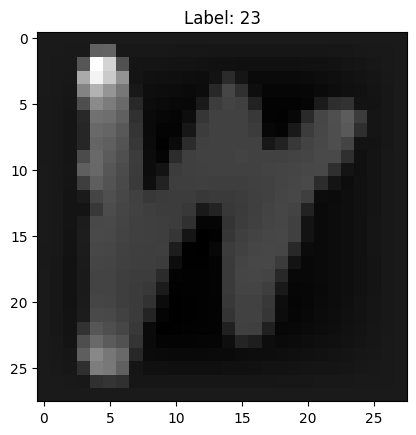

In [10]:
# Extract a sample image
sample = df_letters_train.iloc[0, 1:].values.reshape(28, 28, order="F")

# Plot the image
plt.imshow(sample, cmap='gray')
plt.title(f"Label: {df_letters_train.iloc[0, 0]}")
plt.show()

In [11]:
# Creating train and test matrices from letter dataset

def creating_train_and_test_matrices(train_matrices, test_matrices):
  for label in range(1, 27):
    class_samples = df_letters_train[df_letters_train['label'] == label]

    selected_train_samples = class_samples.iloc[:200, 1:].values
    selected_test_samples = class_samples.iloc[200:220, 1:].values

    train_matrices[label] = selected_train_samples.T

    test_matrices.append(selected_test_samples.T)

  test_matrices = np.concatenate(test_matrices, axis=1)

  class_1_matrix_train = train_matrices[1]

  print("Shape of class 1 (A) train matrix:", class_1_matrix_train.shape)
  print("Type of class 1 train matrix:", type(class_1_matrix_train))
  print("Shape of concatenated test matrices:", test_matrices.shape)

  return train_matrices, test_matrices

# 2. QR decomposition with Householder matrices

In [12]:
# Global Variables

true_labels = np.repeat(np.arange(1, 27), 20)

In [13]:
def qr_decomposition_with_householder(A):
    [m, n] = A.shape
    R = A.copy()
    Q = np.identity(m)

    for i in range(min(m, n)):
        x_i = R[i:, i]
        s = np.sign(x_i[0]) if x_i[0] != 0 else 1
        normx = np.linalg.norm(x_i)
        e1 = np.zeros_like(x_i)
        e1[0] = 1
        v_i = x_i + s * normx * e1
        v_i = v_i / np.linalg.norm(v_i)  # Normalize the Householder vector

        H_i = np.identity(m)
        H_i[i:, i:] -= 2 * np.outer(v_i, v_i)

        R = np.dot(H_i, R)
        Q = np.dot(Q, H_i.T)

    return Q, R


In [14]:
def is_upper_triangular(R):
    return np.allclose(R, np.triu(R))

In [15]:
def is_orthogonal(Q):
    identity = np.eye(Q.shape[0])
    QTQ = np.dot(Q.T, Q)
    return np.allclose(QTQ, identity)

In [16]:
def qr_decomposition_of_all_matrices(train_matrices, Q, R):
  for i in tqdm(range(1, len(train_matrices.keys()) + 1), desc="Generating Q and R matrices for all classes of training matrices"):
    Q_i, R_i = qr_decomposition_with_householder(train_matrices[i])
    Q.append(Q_i)
    R.append(R_i)
    if not is_orthogonal(Q_i):
      print(f"Warning: Q{i} is not Orthogonal")
      print("-" * 30)
    if not is_upper_triangular(R_i):
      print(f"Warning: Q{i} is not Upper Triangle")
      print("-" * 30)

  return Q, R

In [17]:
def predict_labels_using_least_square(test_matrices, Q, R):
    m, n = test_matrices.shape
    predicted_labels = np.zeros(n, dtype=int)
    for i in tqdm(range(n), desc="Predicting Labels"):
        min_score = float('inf')
        for j in range(26):
            # Solve the least squares problem using QR decomposition
            y = np.matmul(Q[j].T, test_matrices[:, i])
            x, residuals, rank, s = np.linalg.lstsq(R[j], y, rcond=1e-5)
            score = np.linalg.norm(np.matmul(R[j], x) - y, 2)
            if score < min_score:
                min_score = score
                predicted_labels[i] = j + 1

    return predicted_labels


In [18]:
def calculate_accuracy(predicted_labels, true_labels, num_classes=26, samples_per_class=20):
    correct_per_class = np.zeros(num_classes, dtype=int)
    total_per_class = np.zeros(num_classes, dtype=int)

    for i, label in enumerate(predicted_labels):
        true_label = true_labels[i]  # Get the corresponding true label
        class_index = true_label - 1  # Assuming labels are 1 to 26

        total_per_class[class_index] += 1  # Count the sample for this class
        if label == true_label:
            correct_per_class[class_index] += 1  # Count correct prediction

    accuracy_per_class = correct_per_class / total_per_class

    overall_accuracy = np.sum(correct_per_class) / np.sum(total_per_class)

    print("Accuracy per class:")
    for class_id in range(num_classes):
        print(f"Class {class_id + 1}: {accuracy_per_class[class_id] * 100:.2f}%")

    print(f"\nOverall Accuracy: {overall_accuracy * 100:.2f}%")
    return accuracy_per_class, overall_accuracy


In [19]:
def pipline_without_updating():
  train_matrices, test_matrices = creating_train_and_test_matrices({}, [])
  Q, R = qr_decomposition_of_all_matrices(train_matrices, [], [])
  predicted_labels = predict_labels_using_least_square(test_matrices, Q, R)
  accuracy_per_class, overall_accuracy = calculate_accuracy(predicted_labels, true_labels)
  return train_matrices, test_matrices, Q, R

In [20]:
train_matrices, test_matrices, Q, R = pipline_without_updating()

Shape of class 1 (A) train matrix: (784, 200)
Type of class 1 train matrix: <class 'numpy.ndarray'>
Shape of concatenated test matrices: (784, 520)


Generating Q and R matrices for all classes of training matrices: 100%|██████████| 26/26 [04:14<00:00,  9.79s/it]
Predicting Labels: 100%|██████████| 520/520 [04:52<00:00,  1.78it/s]

Accuracy per class:
Class 1: 70.00%
Class 2: 60.00%
Class 3: 40.00%
Class 4: 60.00%
Class 5: 70.00%
Class 6: 60.00%
Class 7: 5.00%
Class 8: 45.00%
Class 9: 90.00%
Class 10: 60.00%
Class 11: 60.00%
Class 12: 40.00%
Class 13: 60.00%
Class 14: 65.00%
Class 15: 100.00%
Class 16: 75.00%
Class 17: 60.00%
Class 18: 75.00%
Class 19: 60.00%
Class 20: 70.00%
Class 21: 60.00%
Class 22: 70.00%
Class 23: 75.00%
Class 24: 70.00%
Class 25: 60.00%
Class 26: 75.00%

Overall Accuracy: 62.88%


# 3. QR updating using Givens rotations

In [21]:
def givens_rotation(a, b):
    #  Computes Givens rotation parameters c, s based on Algorithm 1.1.
    if b == 0.0:
        c = 1.0
        s = 0.0
    else:
        if abs(b) >= abs(a):
            t = -a / b
            s_denom = np.sqrt(1.0 + t**2)
            s = 1.0 / s_denom
            c = s * t
        else:
            t = -b / a
            c_denom = np.sqrt(1.0 + t**2)
            c = 1.0 / c_denom
            s = c * t

    return c, s

In [22]:
# Implemented algorithm 2.19 from the paper
def qr_update_append_col(Q, R, u):
    """
    Updates Q and R after appending column u to the original matrix A.
    Assumes A = QR, where Q is m x m (orthogonal) and R is m x n (upper trapezoidal).
    u is a new column of size m x 1.
    Returns updated Q_new (m x m) and R_new (m x (n+1)).
    Uses the c, s from the givens_rotation function implementing Algorithm 1.1.
    """
    m, n = R.shape
    m_q, n_q = Q.shape

    u_transformed = Q @ u

    # Augment R with the transformed column
    R_augmented = np.hstack((R, u_transformed.reshape(-1, 1)))

    #  Apply Givens rotations to zero out elements below the diagonal
    #     in the newly added last column (column index n)
    for i in range(m - 1, n, -1):
        # Target element to zero: R_augmented[i, n]
        # Pivot element: R_augmented[i-1, n]
        a = R_augmented[i - 1, n]
        b = R_augmented[i, n]

        if b != 0.0: # Only need to rotate if the element is non-zero
            # Get Givens parameters from the new function
            c, s = givens_rotation(a, b)

    	      # Givens Matrix
            G = np.array([[c, -s], [s, c]])

            # Apply rotation G to the relevant rows (i-1 and i) of R_augmented
            R_augmented[i - 1:i + 1, :] = G @ R_augmented[i - 1:i + 1, :]

            # Apply the transpose rotation G.T to the corresponding columns (i-1 and i) of Q
            # Q_new = Q_old @ G.T ensures Q_new remains orthogonal
            Q[:, i - 1:i + 1] = Q[:, i - 1:i + 1] @ G.T

    R_new = R_augmented
    Q_new = Q

    return Q_new, R_new

In [23]:
# This function adds each class 20 new data step by step
def qr_decomposition_updating_of_all_matrices(Q, R, df_letters_train, initial_train_size, num_samples_to_add):
  for label in tqdm(range(1, 27), desc="Updating all Q and R matrices"):
    idx = label - 1
    class_samples = df_letters_train[df_letters_train['label'] == label]
    start_idx = initial_train_size
    end_idx = initial_train_size + num_samples_to_add

    samples_to_add_features = class_samples.iloc[start_idx:end_idx, 1:].values.T
    for i in range(num_samples_to_add):
      new_col_u = samples_to_add_features[:, i]
      Q[idx], R[idx] = qr_update_append_col(Q[idx], R[idx], new_col_u)

      if not is_orthogonal(Q[idx]):
        print(f"Warning: Q{idx} is not Orthogonal")
        print("-" * 30)
      if not is_upper_triangular(R[idx]):
        print(f"Warning: R{idx} is not Upper Triangle")
        print("-" * 30)
  return Q, R

In [24]:
def pipline_using_qr_updating(train_matrices, test_matrices, Q, R):
  Q, R = qr_decomposition_updating_of_all_matrices(Q, R, df_letters_train, 300, 20)
  predicted_labels = predict_labels_using_least_square(test_matrices, Q, R)
  accuracy_per_class, overall_accuracy = calculate_accuracy(predicted_labels, true_labels)

In [25]:
pipline_using_qr_updating(train_matrices, test_matrices, Q, R)

Predicting Labels: 100%|██████████| 520/520 [05:37<00:00,  1.54it/s]

Accuracy per class:
Class 1: 70.00%
Class 2: 60.00%
Class 3: 40.00%
Class 4: 60.00%
Class 5: 70.00%
Class 6: 55.00%
Class 7: 5.00%
Class 8: 45.00%
Class 9: 90.00%
Class 10: 60.00%
Class 11: 60.00%
Class 12: 45.00%
Class 13: 60.00%
Class 14: 60.00%
Class 15: 100.00%
Class 16: 75.00%
Class 17: 60.00%
Class 18: 75.00%
Class 19: 65.00%
Class 20: 70.00%
Class 21: 60.00%
Class 22: 75.00%
Class 23: 75.00%
Class 24: 70.00%
Class 25: 60.00%
Class 26: 80.00%

Overall Accuracy: 63.27%
